# AIML338, Time Series Analysis
### Lennox Crowe | Assignment 2

This assignment is inspired by the work done in this paper:
https://arxiv.org/pdf/2408.16187

### Task 0: Data exploration (NZEP)
**Objective:** Visualise selected segments of the data to observe and understand its characteristics.
**Output:** A concise analysis of the NZEP dataset to facilitate its use in the remainder of the assignment.

A point of connection (POC) is a point where electricity flows in or out of the national grid. Electricity pricing information is attributed to a POC. In this assignment, I will focus on POCs WWD1102, WWD1103, which are located at the Makara wind farm near Wellington.


In [6]:
from dataset_generation import get_electricityprice_data
from datetime import date, datetime
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt

I wrote a function in `dataset_generation.py` which retrieves all data within a date range for a set of PointOfConnection ids. The dataset is cached after it is downloaded once. For this EDA, I am going to focus on the last year of data at the makara wind farm.

In [2]:
df_raw = get_electricityprice_data(start_date = date(2024, 8, 10), end_date = date(2025, 8, 10), poc=["WWD1102", "WWD1103"])

Check that the data has been loaded:

In [3]:
df_raw.head()

,TradingDate,TradingPeriod,PublishDateTime,PointOfConnection,Island,IsProxyPriceFlag,DollarsPerMegawattHour
0,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1102,NI,N,834.55
1,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1103,NI,N,834.55
2,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1102,NI,N,831.84
3,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1103,NI,N,831.84
4,2024-08-10,1,2024-08-10T00:09:33.000+12:00,WWD1102,NI,N,833.55


In [4]:
# collect the start time and endtime of the dataset
data_start = df_raw["PublishDateTime"].min()
data_end = df_raw["PublishDateTime"].max()

print("Minimum timestamp: " + str(data_start))
print("Maximum timestamp: " + str(data_end))

Minimum timestamp: 2024-08-10T00:00:00.000+12:00
Maximum timestamp: 2025-08-10T23:54:31.000+12:00


The publish date time will need to be converted to a datetime object.

In [5]:
df_raw["time"] = (pd.to_datetime(df_raw["PublishDateTime"], utc=True))

In [7]:
df_makara_1 = df_raw[df_raw["PointOfConnection"] == "WWD1102"]
df_makara_2 = df_raw[df_raw["PointOfConnection"] == "WWD1103"]

### Check the pricing data and compare the two Point of Connections

Plot the entire time series to check for outliers, seasonality etc. This is done on the entire dataset - but EDA relating to statistical features etc will be done on a dedicated, isolated set to avoid data leakage.

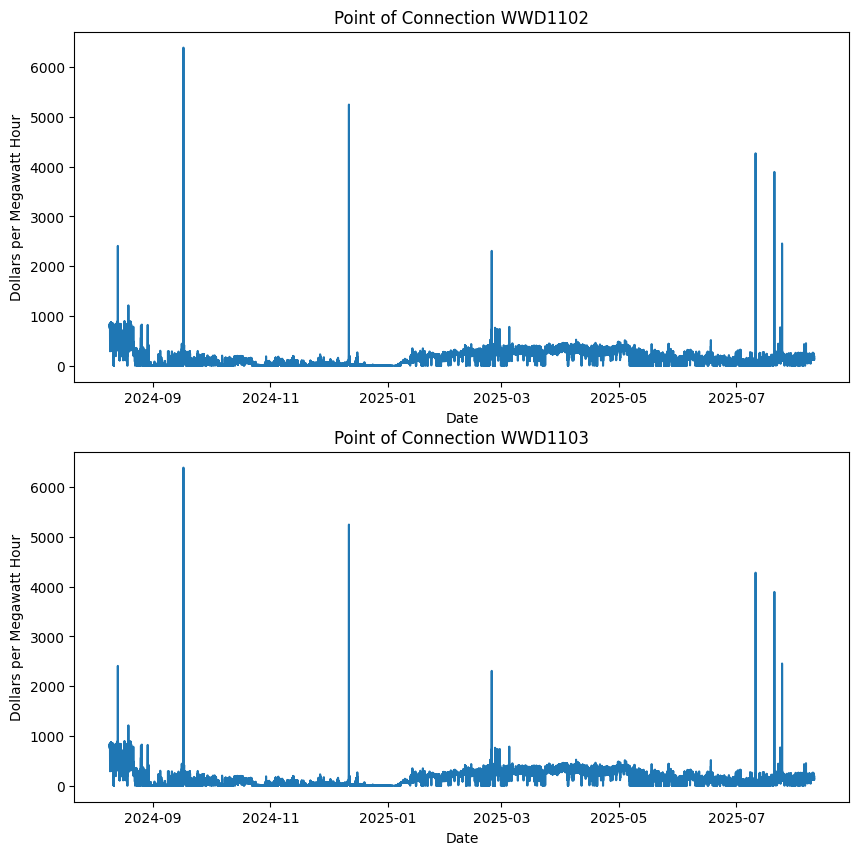

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].plot(df_makara_1["time"], df_makara_1["DollarsPerMegawattHour"])
axes[0].set_title("Point of Connection WWD1102")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Dollars per Megawatt Hour")

axes[1].plot(df_makara_2["time"], df_makara_2["DollarsPerMegawattHour"])
axes[1].set_title("Point of Connection WWD1103")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Dollars per Megawatt Hour")

plt.show()

It appears that both connection points have the same pricing information, so we will continue the analysis looking at just WWD1102. These charts of wholesale electricity price data show that the price is very dynamic, resularly ranging from \\$0 to over \\$500 per MWH. There also isn't a simple seasonal pattern. It is interesting that the price will sometimes go to $0 - I am unsure if this is an error in the dataset, or where electricity is surplus to demand and therefore the price drops to 0.

In [9]:
df_points = df_makara_1[["TradingPeriod", "DollarsPerMegawattHour", "time"]].copy()
df_points["time"] = pd.to_datetime(df_points["time"], utc=True)
df_points = df_points.sort_values("time")

## Validating the intervals between samples
Most time series models will require equal durations between samples. Validate that this is observed in this dataset.

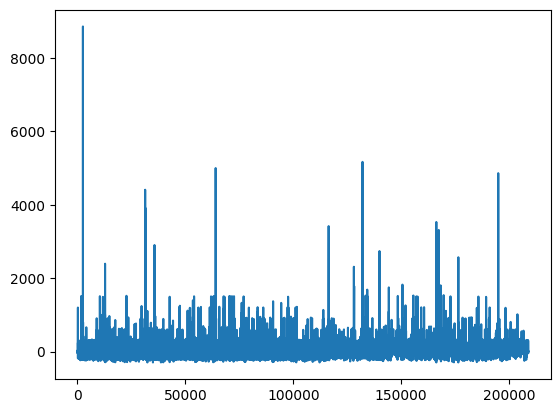

In [10]:
gaps = ((df_points["time"].astype(int)) - (df_points["time"].shift(1).astype(int)))
gaps = (gaps[gaps > 0]/1000000000)
plt.plot(gaps - 300)

There are large inconsistencies in the gaps between samples. This will need to be handled before further analysis.

The plot above displays the time difference between adjacent datapoints, minus the expected interval of 300 seconds (5 minutes). Negative values arrived early, while high values are likely due to gaps in the dataset (due to measurement errors, network outages etc).

In [11]:
print(f"Samples with missing data over 30 mins: {len(gaps[gaps > 60*30])}")
print(f"Samples with missing data over 60 mins: {len(gaps[gaps > 60*60])}")
print(f"Samples with missing data over 120 mins: {len(gaps[gaps > 60*120])}")

Samples with missing data over 30 mins: 40
Samples with missing data over 60 mins: 9
Samples with missing data over 120 mins: 1


Strategy: Make a forecast for each trading period. Take the average value over each trading period. Intervals will be spaced by exactly 30 mins.

In [12]:
dates_df = pd.DataFrame(pd.date_range(start=data_start, end=data_end), columns=["date"])

periods = pd.DataFrame(range(1, 48+1), columns=["TradingPeriod"])

dates_df = dates_df.join(periods, how="cross")
dates_df["date"] = dates_df["date"].dt.date

df_points["date"] = df_points["time"].dt.date

df_complete = pd.merge(df_points, dates_df, how="outer", on=["date", "TradingPeriod"])

df_grouped = (
    df_complete
    .groupby(["date", "TradingPeriod"], as_index=False)
    .agg({
        "DollarsPerMegawattHour": "mean"
    })
)

df_grouped["date"] = pd.to_datetime(df_grouped["date"])

df_grouped["start_time"] = df_grouped["date"] + pd.to_timedelta((df_grouped["TradingPeriod"] - 1) * 30, unit="m")
df_grouped["end_time"] = df_grouped["start_time"] + pd.Timedelta(minutes=30)

df_grouped.isna().sum()

date                       0
TradingPeriod              0
DollarsPerMegawattHour    47
start_time                 0
end_time                   0
dtype: int64

There are 47 missing values. Lets handle these later.

## Feature Engineering

Wind data has been obtained from NIWA: https://data.niwa.co.nz/products/climate-station-hourly/map?bounds=172.16674804687503%2C-42.5854442573849%2C177.791748046875%2C-40.21244071828647

This is from Baring head - the closest weather station with wind data for the required time period. It is worth noting that baring head is at sea level, and on the other side of the wellington harbour compared to the wind farm. However, it can be assumed that there is strong correlation between windspeed at Baring head, and wind speed at Makara.

Wind speed may affect wholesale energy price at Makara, as increased windspeed will result in higher energy supply.

I also downloaded a rainfall dataset from NIWA, recorded at Mt Cook village. This will have an impact on the hydro-lake levels, which are one of the major energy sources in New Zealand.

### Features
I will prepare three features which may influence electricity price:
- `speed`: Windspeed (m/s) at baring head (the closest available windspeed to the makara windfarm).
- `rain`: Rainfall (mm) at Mt Cook village.
- `rain_cumulative`: Rainfall (mm) accumulated in the previous six months.

I decided to generate a feature `rain_cumulative` consisting of the cumulative rainfall over six months before a given time. This would be a better representation of the lake levels than current rainfall.

In [13]:
wind_df = pd.read_csv("./data/wind.csv")
rain_df = pd.read_csv("./data/rain.csv")

In [14]:
wind_df.head()

,Frequency [D/H],Observation time UTC,Data Source,Direction [deg T],PERIOD [hrs],Speed [m/s]
0,H,1991-03-28T03:00:00Z,H,355.0,1.0,10.9
1,H,1991-03-28T04:00:00Z,H,2.0,1.0,10.2
2,H,1991-03-28T05:00:00Z,H,357.0,1.0,10.4
3,H,1991-03-28T06:00:00Z,H,8.0,1.0,9.3
4,H,1991-03-28T07:00:00Z,H,13.0,1.0,9.1


In [15]:
rain_df.head()

,Frequency [D/H],Observation time UTC,Data Source (rainfall),Rainfall [mm],PERIOD [hrs],Deficit [mm],Runoff [mm],Data source (water balance)
0,S,2016-03-02T05:00:00Z,S,0.0,6,NaN,NaN,NaN
1,S,2016-03-02T11:00:00Z,S,0.0,6,NaN,NaN,NaN
2,S,2016-03-02T17:00:00Z,S,0.0,6,NaN,NaN,NaN
3,S,2016-03-02T23:00:00Z,S,0.0,6,NaN,NaN,NaN
4,S,2016-03-03T05:00:00Z,S,0.0,6,NaN,NaN,NaN


In [20]:
# convert timestamps to datetime
rain_df["Observation time UTC"] = pd.to_datetime(rain_df["Observation time UTC"])
wind_df["Observation time UTC"] = pd.to_datetime(wind_df["Observation time UTC"])

# lag the timestamp column for the period over which the wind and rain data was recorded over.
# this will make it easier to join onto the POC dataset - i.e. join between a timestamp range.
rain_df["Observation Start"] = rain_df["Observation time UTC"].shift(1)
wind_df["Observation Start"] = wind_df["Observation time UTC"].shift(1)

rain_df_filter = rain_df[rain_df['Frequency [D/H]'] == "S"] # this appears to be collected every six hours, at 5am/pm and 11am/pm
wind_df_filter = wind_df[wind_df['Frequency [D/H]'] == "H"]

I am going to compute a column "rolling cumulative rainfall past 6 months" for the rainfall dataset, to represent the previous rainfall conditions.

In [21]:
rain_df_filter["Cumulative Rainfall"] = rain_df_filter["Rainfall [mm]"].rolling(window=4*7*21).sum()

rain_df_filter = rain_df_filter[["Observation time UTC", "Observation Start", "Rainfall [mm]", "Cumulative Rainfall"]]
wind_df_filter = wind_df_filter[["Observation time UTC", "Observation Start", "Speed [m/s]"]]

wind_na_rm = wind_df_filter.dropna()
rain_na_rm = rain_df_filter.dropna()

rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)

C:\Users\lenno\AppData\Local\Temp\ipykernel_16140\3363435012.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
C:\Users\lenno\AppData\Local\Temp\ipykernel_16140\3363435012.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)


Merging between timestamps in pandas is difficult. Using a cross-join and a filter is impossible for datasets of this size, but fortunately a function `merge_asof` can be used to merge on the 'nearest distance' i.e. nearest matching timestamps.

In [22]:
datetime_format = "%Y-%m-%dT%H:%M:%S.%f%z"

# filter the datasets to a time series which matches the energy dataset

rain_final = rain_na_rm[
    (rain_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (rain_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

wind_final = wind_na_rm[
    (wind_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (wind_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

# preprocessing to merge

df_grouped["start_time"] = pd.to_datetime(df_grouped["start_time"])
df_grouped["end_time"] = pd.to_datetime(df_grouped["end_time"])

rain_intervals = rain_final[["start", "end", "rain", "rain_cumulative"]].copy()
rain_intervals["start"] = pd.to_datetime(rain_intervals["start"])
rain_intervals["end"]   = pd.to_datetime(rain_intervals["end"])
rain_intervals = rain_intervals.sort_values("start")

wind_intervals = wind_final[["start", "end", "speed"]].copy()
wind_intervals["start"] = pd.to_datetime(wind_intervals["start"])
wind_intervals["end"]   = pd.to_datetime(wind_intervals["end"])
wind_intervals = wind_intervals.sort_values("start")

df_grouped["start_time"] = df_grouped["start_time"].dt.tz_localize("UTC")
df_grouped["end_time"] = df_grouped["end_time"].dt.tz_localize("UTC")

rain_intervals["start"] = rain_intervals["start"].dt.tz_convert("UTC")
rain_intervals["end"] = rain_intervals["end"].dt.tz_convert("UTC")

wind_intervals["start"] = wind_intervals["start"].dt.tz_convert("UTC")
wind_intervals["end"] = wind_intervals["end"].dt.tz_convert("UTC")

df_grouped.sort_values("start_time", inplace=True)
rain_intervals.sort_values("start", inplace=True)
wind_intervals.sort_values("start", inplace=True)

# merge_asof = nearest previous start
df_grouped_rain = pd.merge_asof(
    df_grouped,
    rain_intervals,
    left_on="start_time",
    right_on="start",
    direction="backward",
)

df_grouped_rain = df_grouped_rain[df_grouped_rain["end_time"] <= df_grouped_rain["end"]].copy()

df_all_features = pd.merge_asof(
    df_grouped_rain,
    wind_intervals,
    left_on="start_time",
    right_on="start",
    direction="backward",
    suffixes=('_rain', '_wind')
)

In [23]:
# filter to the features we will use
df_all_features = df_all_features[["date", "TradingPeriod", "start_time", "end_time", "DollarsPerMegawattHour", "rain", "rain_cumulative", "speed"]]

## Validating Windspeed and Rainfall

Plotting the values for windspeed and rainfall, to check for outliers and sense-check the data.

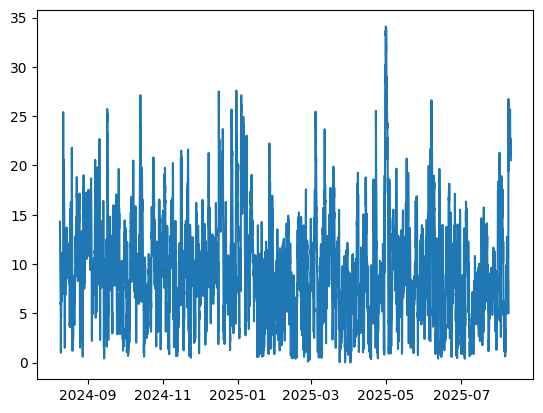

In [24]:
plt.plot(df_all_features["start_time"], df_all_features["speed"])

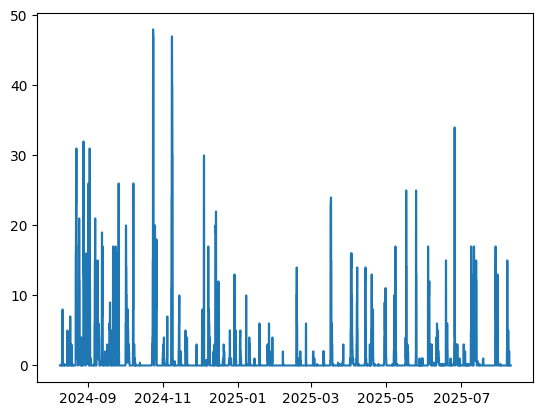

In [25]:
plt.plot(df_all_features["start_time"], df_all_features["rain"])

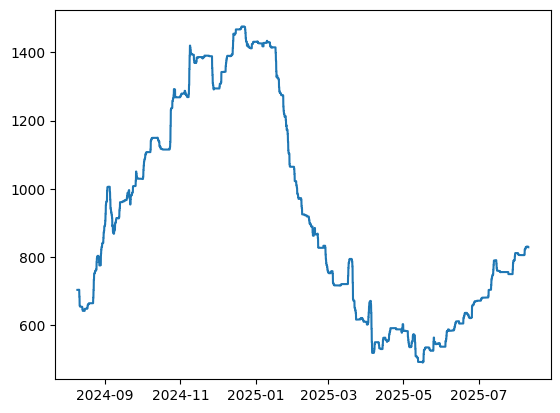

In [26]:
plt.plot(df_all_features["start_time"], df_all_features["rain_cumulative"])

Everything seems to conform to expectation. Windspeed fluctuates significantly, never getting below 0, and occasionally getting up to 35m/s (126km/h) which can be expected for the Wellington region. The rainfall data also makes sense, with many days of 0mm rain, and some days of up to 50mm rain. When a rolling sum over six months is taken, the winter period results in a large cumulative rainfall which lines up with summer. While this may not be the most logical way to represent this data to a person, (high cumulative rainfall in summer seems confusing) the actual numerical values shouldn't matter for statistical/machine learning methods.

## Filling Missing Values
There are 35 trading periods where there are missing values for DollarsPerMegawattHour.

In [27]:
df_all_features.isna().sum()

date                       0
TradingPeriod              0
start_time                 0
end_time                   0
DollarsPerMegawattHour    35
rain                       0
rain_cumulative            0
speed                      0
dtype: int64

35 missing values for half-hourly data over a year-long period aren't going to significantly impact the prediction quality. Many statistical methods for time-series forecasting can't handle missing values in the predictor variable, so an interpolation approach is appropriate. This will also be appropriate for a machine learning forecast method - but in this case, the missing values could also be dropped from the dataset. All things considered, interpolation is the best approach for handling these missing values.

In [28]:
df_all_features = df_all_features.set_index("start_time")

df_all_features["DollarsPerMegawattHour"] = (
    df_all_features["DollarsPerMegawattHour"]
    .interpolate(method="time")
)

df_all_features.reset_index(inplace=True)

In [29]:
df_final = df_all_features.copy()

## Split into a train and test set

## Cross-validation - TimeSeriesSplit

To avoid data leakage, we should split into train and test sets before doing any more EDA. When dealing with time series data, we cannot train on future observations (otherwise the test accuracy would be biased). SKLearn provides the function `TimeSeriesSplit` to perform a 'rolling window evaluation'. This is essentially time-based cross validation. Rolling window evaluation differs from sliding window evaluation, which increments the training set forward by one observation each window - evaluating every subset of train/test data. This is only appropriate for small datasets as it gets computationally expensive on large datasets. I wanted to control the train, test, and rolling window length using time, not a number of observations. This is not supported by SKLearn's `TimeSeriesSplit`, so I wrote my own function to do the split instead.

Strategy:
- Get one years worth of data
- Perform EDA on the first six months
- Do a cross validation TimeSeriesSplit

In [30]:
# first six months
df_eda = df_final[(df_final["start_time"] < df_final["start_time"].min() + pd.Timedelta(days=180))]
df_train = df_final[(df_final["start_time"] > df_final["start_time"].min() + pd.Timedelta(days=180))]

In [31]:
def time_series_split_by_timerange(df, jump_length="1D", window_size_length="1D", time_col="start_time"):
    df = df.sort_values(time_col)
    window_size = pd.Timedelta(window_size_length)
    jump_size = pd.Timedelta(jump_length)

    start_time = df[time_col].min() + window_size
    end_time = df[time_col].max()

    splits = []

    while start_time + jump_size <= end_time:
        train_idx = df[(df[time_col] < start_time) & (df[time_col] > start_time - window_size)].index
        test_idx = df[(df[time_col] >= start_time) & (df[time_col] < start_time + jump_size)].index
        if len(test_idx) == 0:
            break
        splits.append((train_idx, test_idx))
        start_time += jump_size
    return splits

def get_data(df, split):
    return df.iloc[split[0]], df.iloc[split[1]]

# Fitting ARIMA models

ARIMA models perform one-step ahead prediction, and then use recursive prediction to generate a forecast. As prediction errors will accumulate, ARIMA models aren't good at predicting a long way into the future. For these experiments, ARIMA models will be fit to one day (48 steps) of training data, and their predictive performance over 1 step (half an hour) and 12 steps (6 hours) will be calculated. Evaluation will be performed with Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). When evaluating MSE and RMSE over the 12 step period, the MSE and RMSE values over all steps will be aggregated - so the errors between one step and 12 step forecasts will not be directly comparable. However, the MSE and RMSE over 12 steps will be comparible between ARIMA models.

Two types of models will be fit:
- ARIMA for forecasting based purely off the behaviour of the response variable `DollarsPerMegawattHour`. No exogenous variables are used in the prediction.
- ARIMAX for forecasting based off the response variable `DollarsPerMegawattHour`, but also a linear combination of exogenous variables `speed` (wind-speed at Makara), `rain` (rainfall at Mt Cook village), and `rain_cumulative` (cumulative rainfall at Mt Cook village).

It is worth noting that the cumulative rainfall feature becomes essentially irrelevant, when using it in the ARIMAX model. This is because the cumulative rainfall over the past six months won't change enough within one day to have a real-life effect on energy prices.

Before fitting ARIMA or ARIMAX models, the parameters need to be found:

## Augmented Dickey-Fuller (ADF) test for Stationary time series

An ARIMA model will only work with a stationary time series.

- A stationary time series has constant statistical properties over time.
- The ADF test checks for a unit root. A unit root is characteristic of non-stationary data.
- A 'unit root' would mean that a shock to the series has a permanent effect (i.e. the series would drift over time and not revert to the mean. This is not characteristic of stationary data...).
- A small p-value would indicate a stationary time series.
- To apply an ARIMA model, the time series should be differenced until the time series is stationary.

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
adf_test = adfuller(df_train["DollarsPerMegawattHour"])

In [34]:
# find the p-value
adf_test[1]

np.float64(0.001435094985603007)

The p-value is very small, so we can reject the null hypothesis (the series has a unit root) and claim that the time series is stationary without differencing. This means the `d` parameter for ARIMA is 0.

## Parameters `p` and `q`

- Parameter `p` represents the correlation between $y_t$ and $y_{t-k}$ after removing the effects of lags $1, 2, ..., k-1$. This can be found using the partial-autocorrelation function, and observing when a sharp drop is found.
- Parameter `q` represents the correlation between $y_t$ and $y_{t-k}$ for all lags of `k`. A suitable value for the `q` parameter is found where there is a significant drop in this function.

In [35]:
splits = time_series_split_by_timerange(df_train)

# Part 1: ARIMA

The ARIMA parameters are being found on the EDA set to avoid data leakage. Finding these parameters using the evaluation set would lead to biased evaluations of the data, as choices relating to model configuration were made on the same dataset.

In [36]:
# work on df_train to mitigate data leakage
series_eda = df_eda[["start_time", "DollarsPerMegawattHour"]]

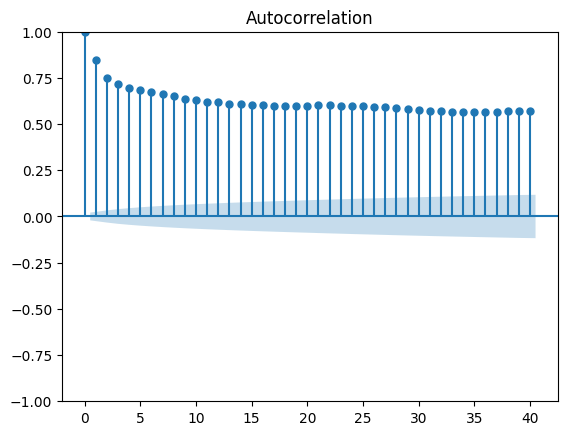

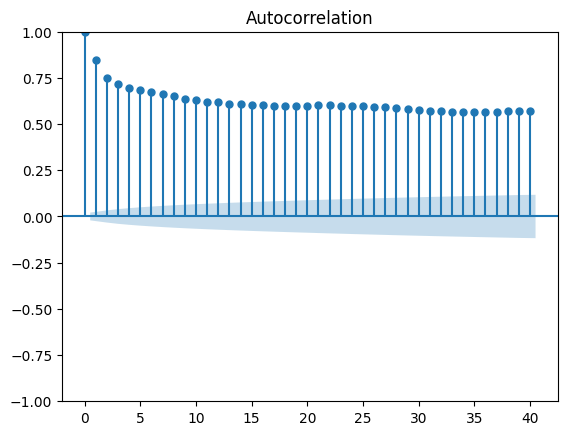

In [37]:
# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_eda["DollarsPerMegawattHour"], lags=40)

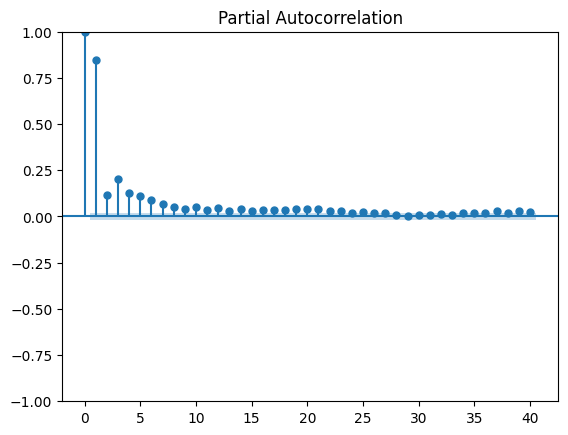

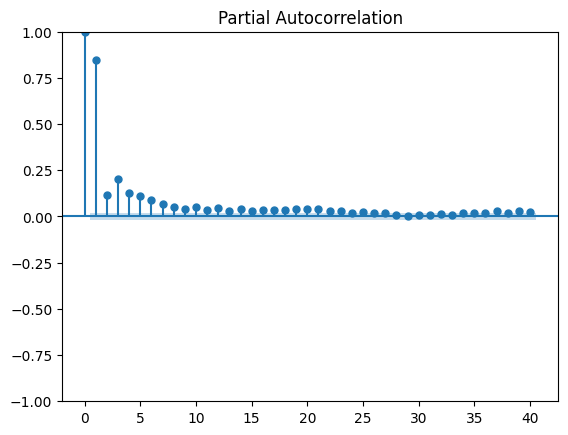

In [38]:
plot_pacf(df_eda["DollarsPerMegawattHour"], lags=40)

The autocorrelation function never really saw a sharp drop in correlation. The sharpest drop would be at `lag = 2`, but even then, this isn't particularly convincing.

The partial autocorrelation function shows a much sharper drop at `lag = 2`, meaning that this is likely the appropriate parameter value for `q`.

In [39]:
# define the ARIMA and ARIMAX parameters

p = 2
d = 2
q = 0

### Custom functions for model fitting and evaluation

For consistency and reproducability to perform rolling window evaluation over the ARIMA models, some custom functions are defined.

In [41]:
# prepare datasets for rolling window evaluation
datasets = time_series_split_by_timerange(df_final)

In [42]:
# store outputs from the evalution function in this data structure

class ChartOutput:
    def __init__(self, train, test, model):
        self.train = train
        self.test = test
        self.model = model

In [43]:
# surpressing warnings generated because of the timestamp index. I correctly spaced it manually.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")


In [44]:
from statsmodels.tsa.arima.model import ARIMA

outputs = []

# this is the main training loop
for dataset in datasets:
    train_idx, test_idx = dataset

    train_set = df_final.iloc[train_idx]
    test_set = df_final.iloc[test_idx]

    model = ARIMA(train_set["DollarsPerMegawattHour"], order=(p, d, q))

    outputs.append(ChartOutput(train_set, test_set, model))


In [45]:
# evaluation function for:
# finding MSE and RMSE both over just the first predition, and also the test_plot_steps length forecast
# plotting a few samples from the rolling window evaluation
def evaluate_timeseries(outputs, forecast_steps=12, plot_context_steps = 24, test_plot_steps = 12, plot_limit = 5, exog=None):

    count = 0

    all_one_step_errors = []
    all_multi_step_errors = []

    for i, out in enumerate(outputs, start=1):

        do_plot = True

        if count >= plot_limit:
            do_plot = False

        train_set, test_set, model = out.train, out.test, out.model

        train_set = train_set.set_index("start_time")
        test_set = test_set.set_index("start_time")

        res = model.fit()

        forecast_steps_adj = min(forecast_steps, len(test_set))

        if exog is not None:
            forecast = res.forecast(steps=forecast_steps_adj, exog=test_set[exog].iloc[:forecast_steps_adj])
        else:
            forecast = res.forecast(steps=forecast_steps_adj)

        forecast_index = test_set.index[:forecast_steps_adj]
        forecast.index = forecast_index

        y_true = test_set["DollarsPerMegawattHour"].iloc[:forecast_steps_adj]
        y_pred = forecast

        one_step_true = y_true.iloc[0]
        one_step_pred = y_pred.iloc[0]

        all_one_step_errors.append((one_step_true - one_step_pred) ** 2)
        all_multi_step_errors.extend((y_true - y_pred) ** 2)

        if forecast_index[0] - train_set.index[0] < pd.Timedelta(minutes=30*plot_context_steps):
            plot_start = train_set.index[0]
        else:
            plot_start = forecast_index[0] - pd.Timedelta(minutes=30*plot_context_steps)

        train_plot = train_set[train_set.index >= plot_start]
        test_plot = test_set[test_set.index >= plot_start].iloc[:test_plot_steps]

        if do_plot:
            plt.figure(figsize=(12,6))
            plt.plot(train_plot.index, train_plot["DollarsPerMegawattHour"], label="Train", color="blue")
            plt.plot(test_plot.index, test_plot["DollarsPerMegawattHour"], label="Test", color="black")
            plt.plot(forecast.index, forecast, label="Forecast", color="red", linestyle="--")

            plt.scatter(forecast.index[0], forecast.iloc[0], color="green", s=80, zorder=5, label="One-step ahead prediction")
            plt.scatter(test_plot.index[0], test_plot["DollarsPerMegawattHour"].iloc[0], color="yellow", s=80, zorder=5, label="One-step ahead truth")


            plt.title(f"ARIMA Forecast vs Test Set (Model {i})")
            plt.xlabel("Time")
            plt.ylabel("Dollars per MWh")
            plt.legend()
            plt.tight_layout()
            plt.show()

        count += 1

    one_step_mse = np.mean(all_one_step_errors)
    one_step_rmse = np.sqrt(one_step_mse)

    multi_step_mse = np.mean(all_multi_step_errors)
    multi_step_rmse = np.sqrt(multi_step_mse)

    print("Forecast Performance:")
    print(f"One-step ahead MSE: {one_step_mse:.4f}")
    print(f"One-step ahead RMSE: {one_step_rmse:.4f}")
    print(f"Multi-step MSE: {multi_step_mse:.4f}")
    print(f"Multi-step RMSE: {multi_step_rmse:.4f}")

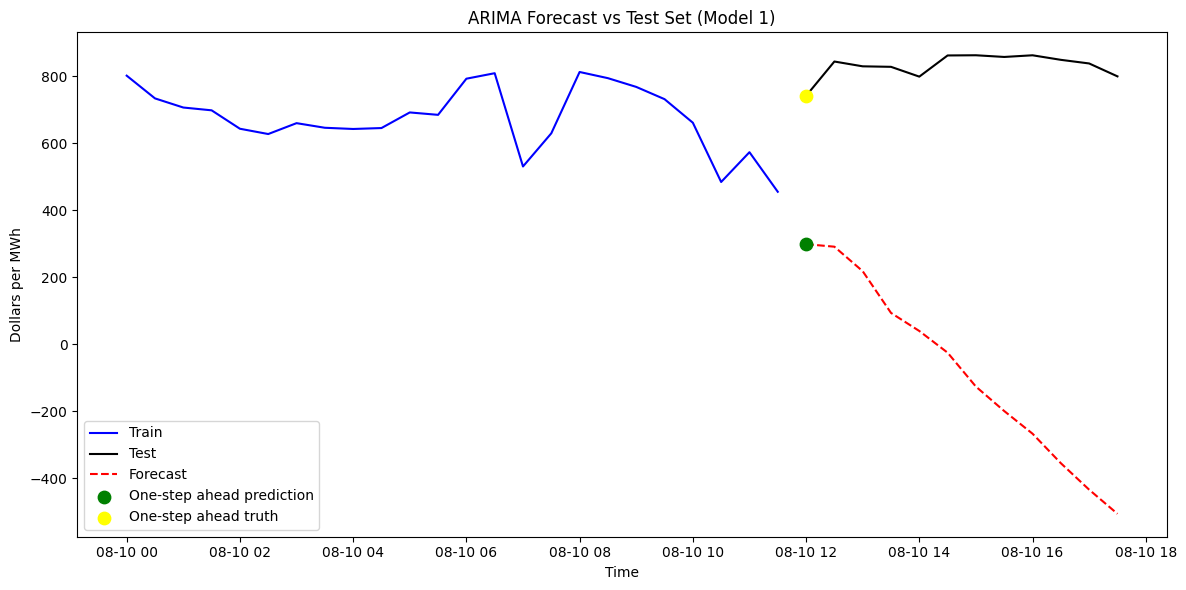

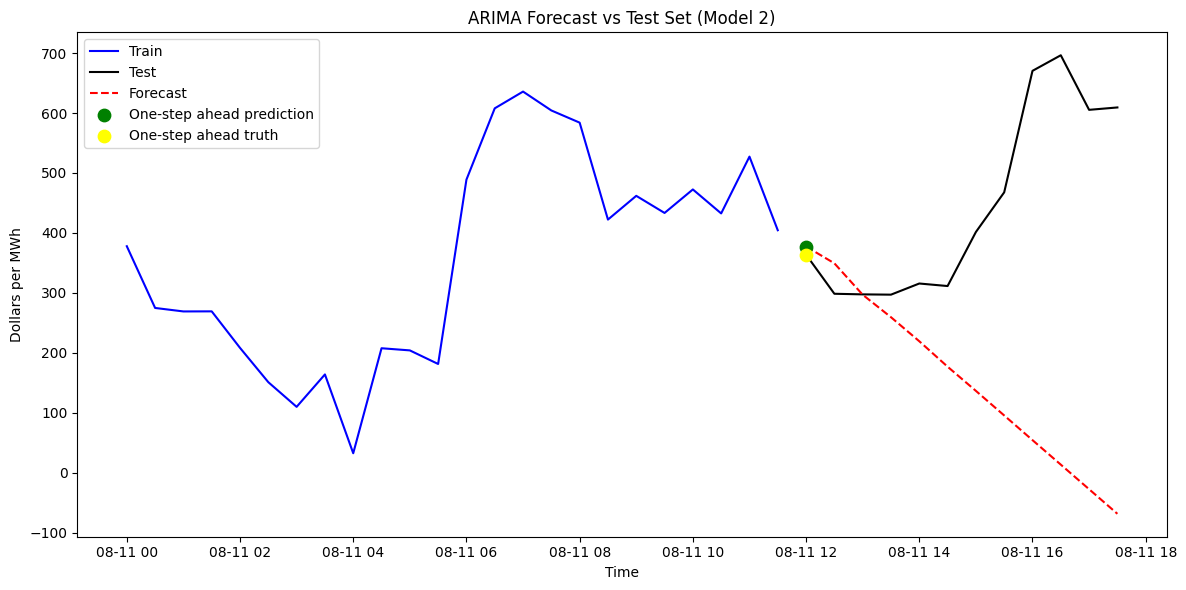

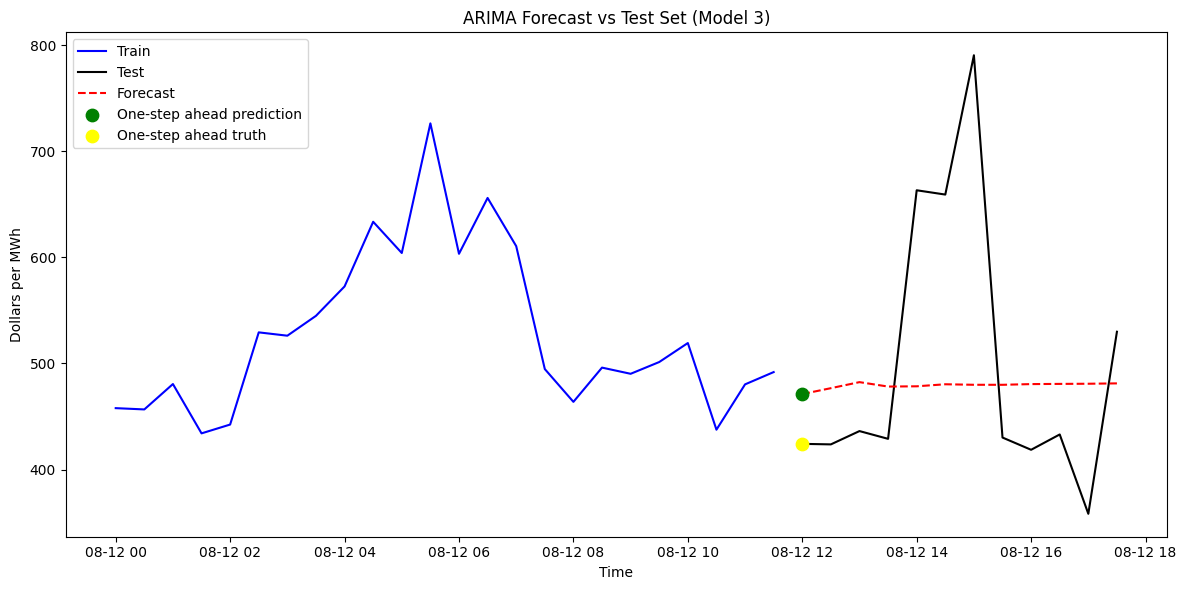

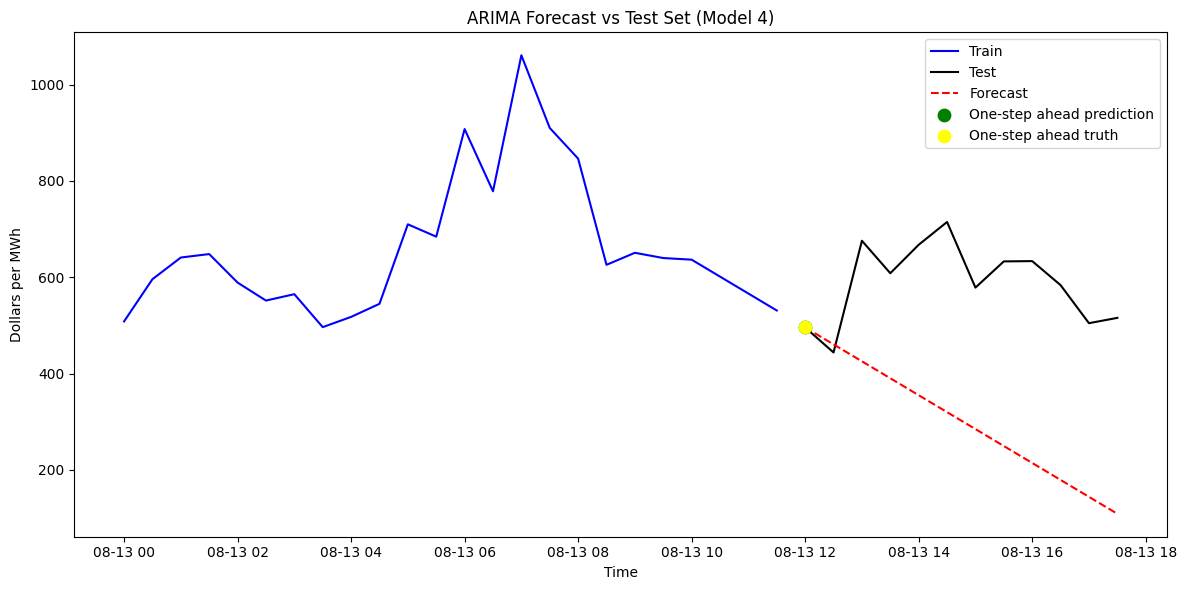

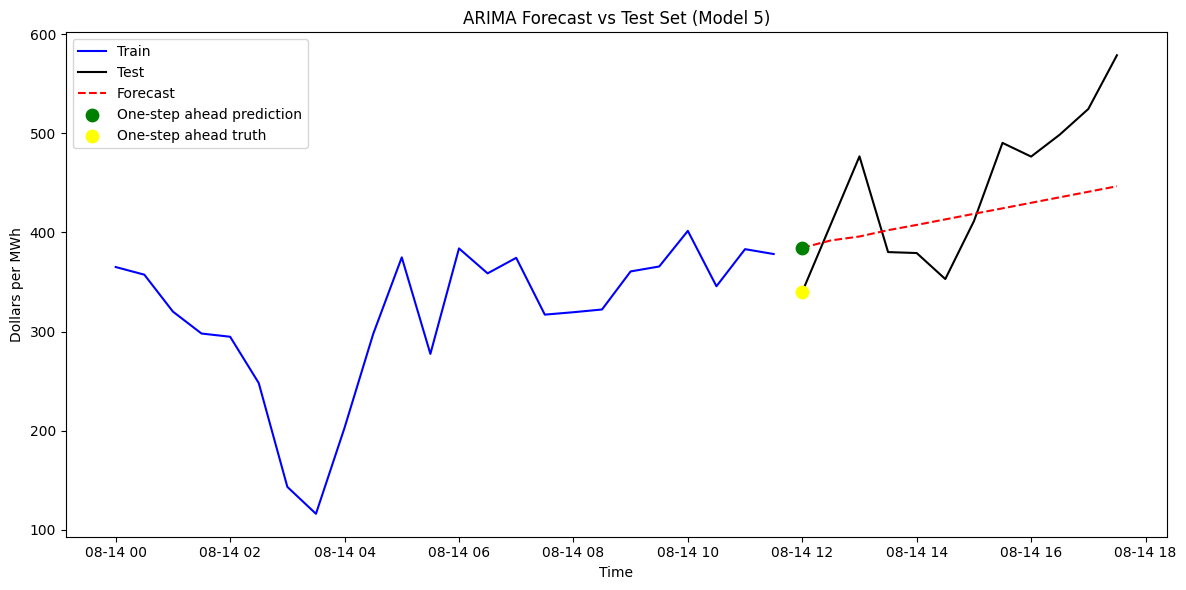

Forecast Performance:
One-step ahead MSE: 11276.1377
One-step ahead RMSE: 106.1892
Multi-step MSE: 1336851.1654
Multi-step RMSE: 1156.2228


In [46]:
# evaluate an ARIMA model for this task
evaluate_timeseries(outputs)

## ARIMA evaluation

It is important to note that the ARIMA models use no more than two points of 'context' when generating a forecast, as the `p` and `q` parameters are both set to $2$. This means that the models are heavily influenced by the trend direction of the two points preceding the prediction. The model structure is more complex than a generating a simple linear extrapolation, but due to the randomness of the input data, the models don't seem to find a good fit. This leads to them effectively just continuing the trend from the previous two points before the forecast. The randomness and variability of this dataset aren't well suited to an ARIMA model. ARIMA tends to perform better on datasets with predictable trend and seasonality, where there is complex but predictable correlation between points over a lag period. The electricity dataset seems to have too much randomness and variability for an ARIMA model to find useful correlations between the time series and a lagged version of itself.

## Fitting ARIMAX

ARIMAX is a modified version of the ARIMA model, but incorporates exogenous predictor variables into the model. This is useful for time series which are influenced by external factors. It seems reasonable that electricity price would be influenced by external factors (especially environmental factors, which would impact both the supply and demand of electricity production). The dataset prepared for this analysis includes three exogenous variables `rain`, `speed`, and `rain_cumulative`, which were defined earlier in the notebook.


In [47]:
outputs_arimax = []

vars = ["speed", "rain", "rain_cumulative"]

# define the training loop for ARIMAX (rolling window evaluation)
for dataset in datasets:
    train_idx, test_idx = dataset

    train_set = df_final.iloc[train_idx]
    test_set = df_final.iloc[test_idx]

    model = ARIMA(train_set["DollarsPerMegawattHour"], exog=train_set[vars], order=(p, d, q))

    outputs_arimax.append(ChartOutput(train_set, test_set, model))

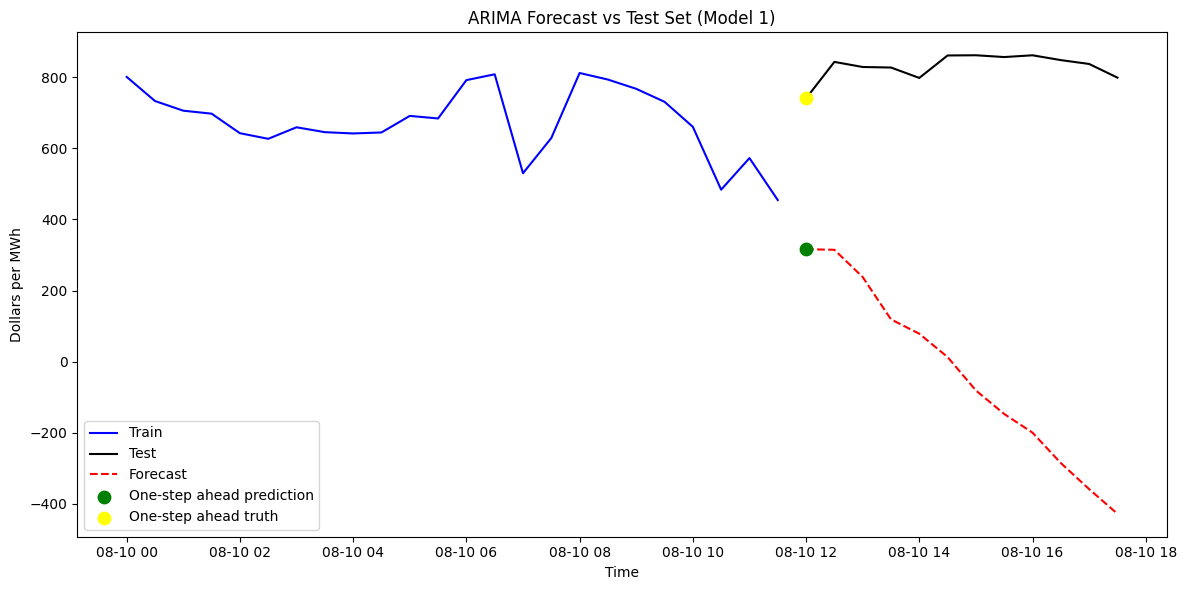

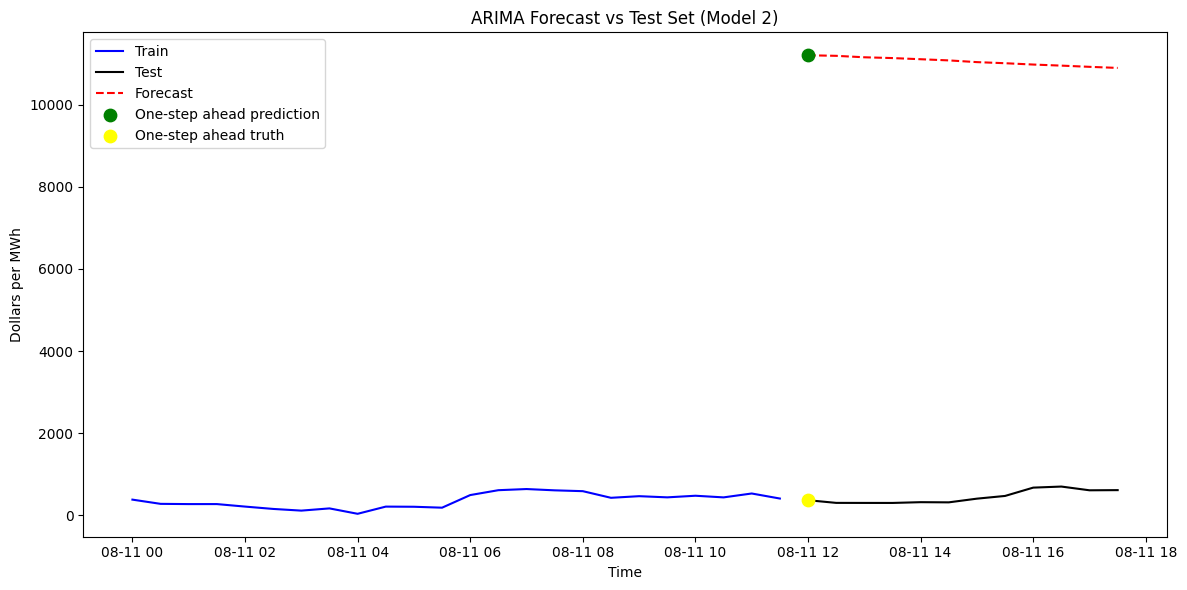

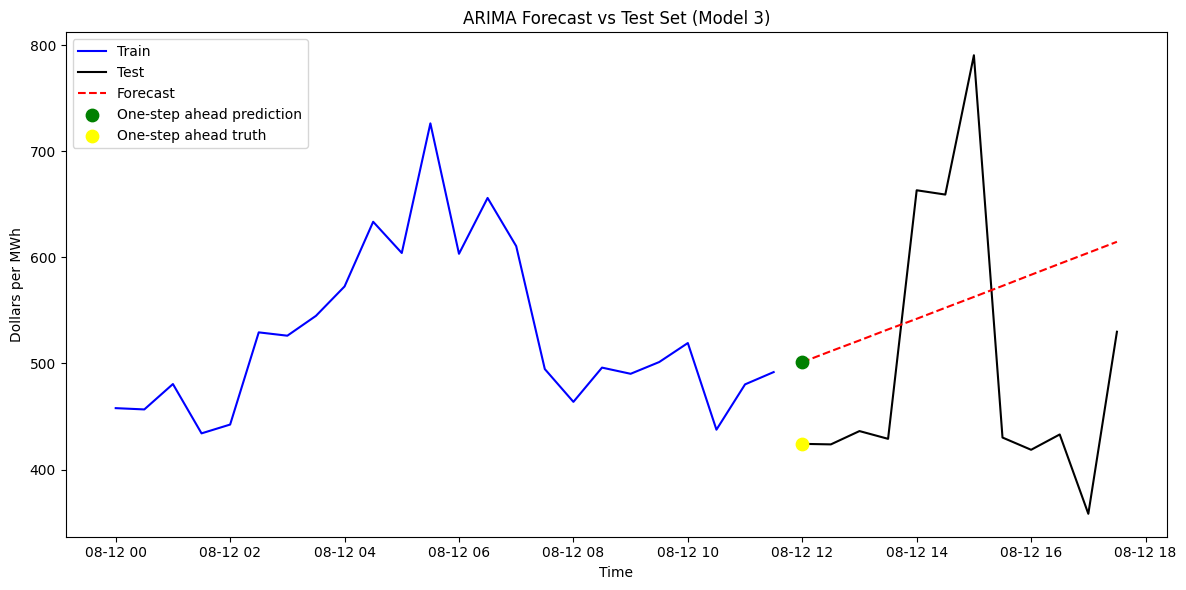

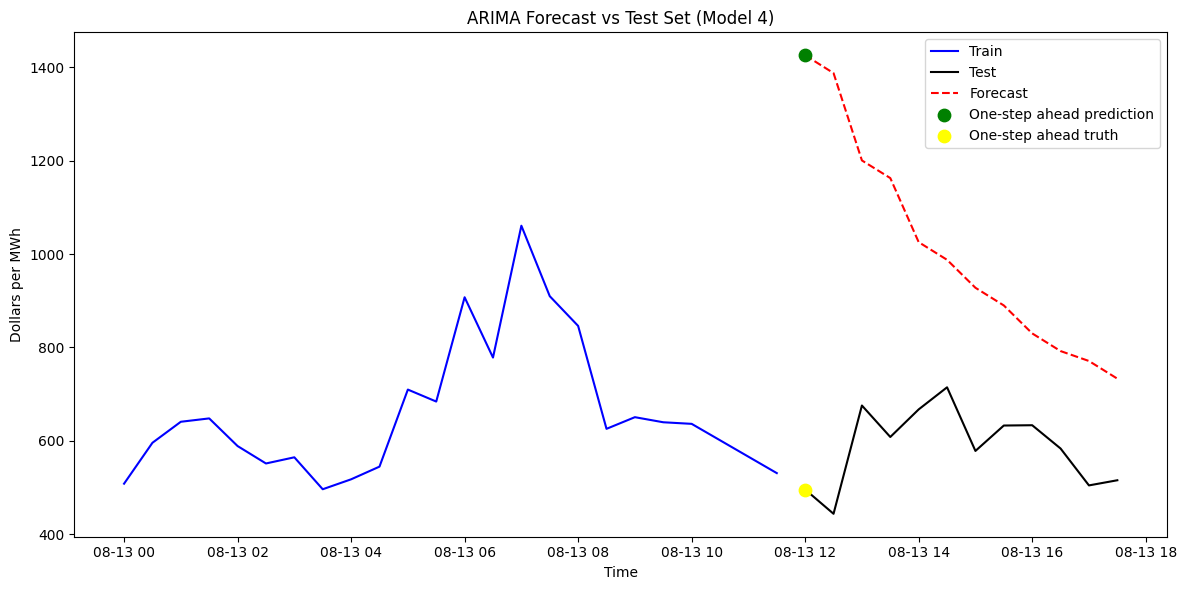

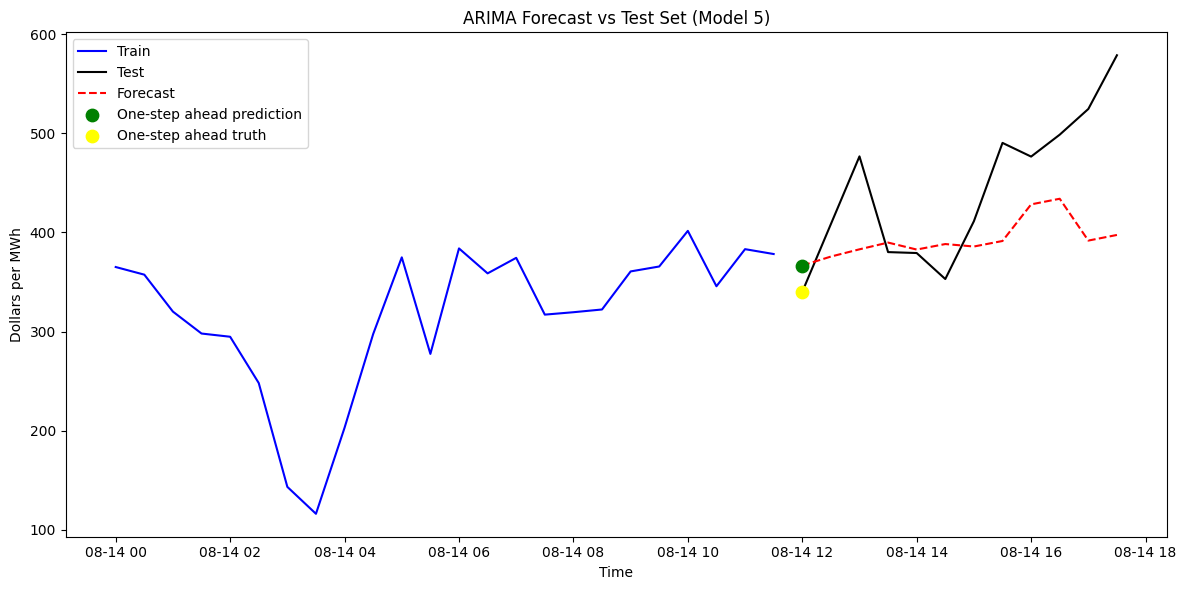

Forecast Performance:
One-step ahead MSE: 9650532.8876
One-step ahead RMSE: 3106.5307
Multi-step MSE: 10544891.2998
Multi-step RMSE: 3247.2898


In [48]:
evaluate_timeseries(outputs_arimax, exog=vars)

### ARIMAX Evaluation
The ARIMAX model saw similar results to the ARIMA model - being largely influenced by the previous two datapoints and generating a forecast based off this trend. However, sometimes predictions were wildly different to what was observed leading up to the forecast. It is worth noting that the exogenous variables `speed`, `rain`, and `rain_cumulative` likely have little-to-no real correlation to wholesale energy price. As each model was trained over 48 steps (24 hours), sometimes a misleading correlation with an exogenous variable might be found, by chance. When a misleading correlation is found, the forecasts are likely to be wildly unpredictable, as they are influenced by what is essentially a random variable. It appears some of the example models in the charts above experienced this. In some cases, the example models made similar forecasts to what was observed by the ARIMA model without exogenous predictors. This was likely in cases where there was no correlation between the exogenous predictors and the target, so the exogenous variables were largely ignored (given small coefficients) and the ARIMAX model was effectively just an ARIMA model.

Note that these forecasts are generated using true values of `speed`, `rain`, and `rain_cumulative`. These would need to be attained by a forecast in a true implementation of this model, likely reducing performance if the exogenous variables are actually correlated with the time series.

 # Part 2: Forecasting with TsFresh



In [54]:
from tsfresh.feature_extraction import extract_features, settings

X_vars = ["id", "start_time", "DollarsPerMegawattHour", "speed", "rain", "rain_cumulative"]
y_var = "DollarsPerMegawattHour"

split_idx = int(len(df_final) * 0.8)
df_train = df_final.iloc[:split_idx]
df_test = df_final.iloc[split_idx:]

def make_windowed_dataset(df, forecast_steps=1, intervals_preceding_length=7*48, jump=10):
    """Turn a continuous time series into tsfresh-ready windows."""
    windowed_dfs = []
    y_values = []
    ids = []
    pred_times = []

    for i, pos in enumerate(range(0, len(df) - intervals_preceding_length - forecast_steps, jump)):

        x_end_idx = pos + intervals_preceding_length
        y_end_idx = pos + intervals_preceding_length + forecast_steps

        window = df.iloc[pos:x_end_idx].copy()
        anchor_time = df.iloc[x_end_idx]["start_time"]
        pred_time = df.iloc[y_end_idx]["start_time"]

        window["id"] = anchor_time
        windowed_dfs.append(window[X_vars])

        y_values.append(df.iloc[y_end_idx][y_var])
        ids.append(anchor_time)
        pred_times.append(pred_time)

    return (
        pd.concat(windowed_dfs),
        pd.Series(y_values, index=ids),
        pd.Series(pred_times, index=ids, name="prediction_time")
    )

In [55]:
from numpy import random
from sklearn.metrics import mean_squared_error

def test_model(df_train, df_test, model, lookahead=1, samples=5, context=48, future=24, name="Unnamed Model"):

    df_train_windows, y_train, train_pred_times = make_windowed_dataset(df_train, forecast_steps=lookahead)
    X_train = extract_features(
        df_train_windows,
        column_id="id",
        column_sort="start_time",
        default_fc_parameters=settings.MinimalFCParameters()
    )

    df_test_windows, y_test, test_pred_times = make_windowed_dataset(df_test, forecast_steps=lookahead)
    X_test = extract_features(
        df_test_windows,
        column_id="id",
        column_sort="start_time",
        default_fc_parameters=settings.MinimalFCParameters()
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    print(f"Results for {name}:")
    print(f"MSE = {mse}")
    print(f"RMSE = {rmse}")

    maxidx = len(X_test) - 1

    for i in random.randint(0, len(X_test)-1, samples):
        anchor_time = X_test.index[i]          # end of lookback
        prediction_time = test_pred_times.iloc[i]  # actual forecast timestamp
        prediction = preds[i]
        true = y_test.iloc[i]

        df_context = df_test[df_test["start_time"] <= anchor_time].tail(context).set_index("start_time")["DollarsPerMegawattHour"]
        df_future = df_test[df_test["start_time"] >= anchor_time].head(future+lookahead).set_index("start_time")["DollarsPerMegawattHour"]

        plt.figure(figsize=(10,4))
        plt.plot(df_context.index, df_context.values, label="Context")
        plt.plot(df_future.index, df_future.values, label="Future")
        plt.plot(prediction_time, prediction, 'ro', label="Prediction")
        plt.plot(prediction_time, true, 'bo', label="True")
        plt.axvline(anchor_time, color="gray", linestyle="--", alpha=0.5)
        plt.legend()
        plt.title(f"Sample {i} prediction | {name}")
        plt.show()

        #print(f"MSE: {this_mse} \n RMSE: {this_rmse}")

## Linear Regression

In [56]:
# forecasting the first step ahead with linear regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

regression_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Results for Linear Regression, Lookahead = 1:
MSE = 4700.569710181547
RMSE = 68.56070091664427


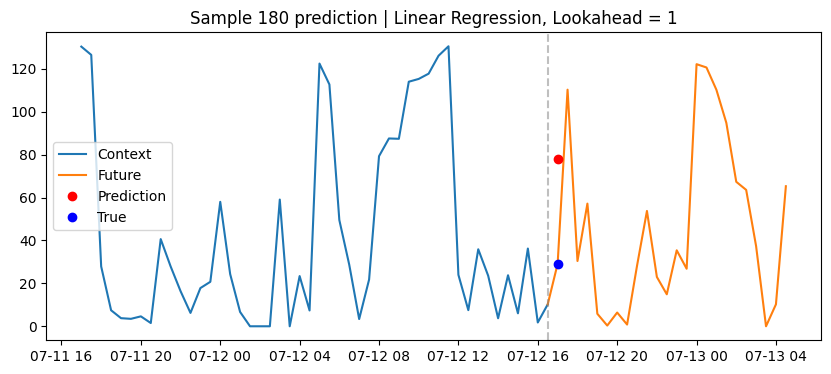

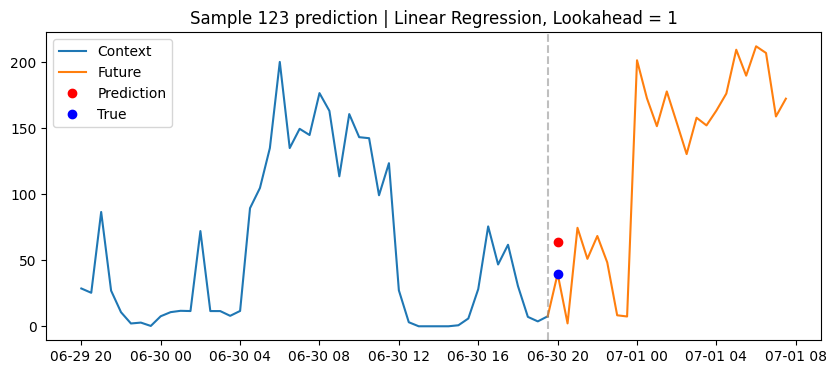

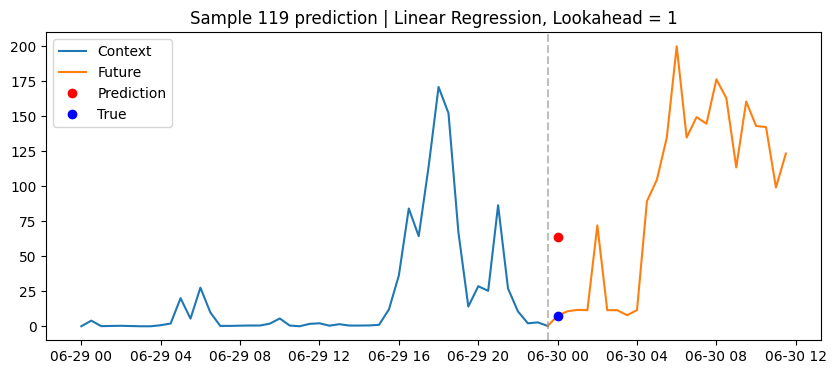

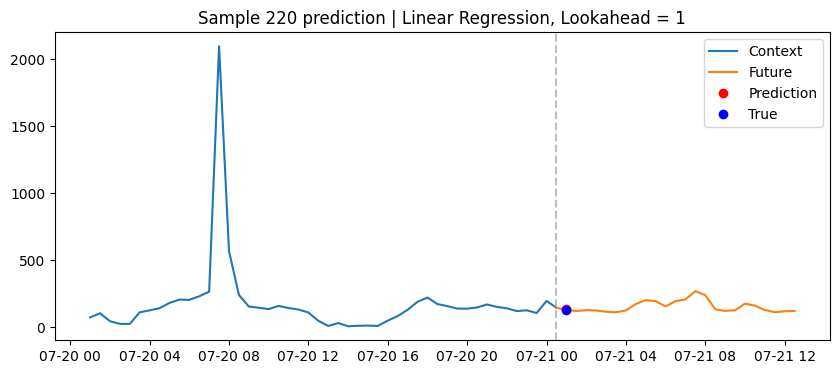

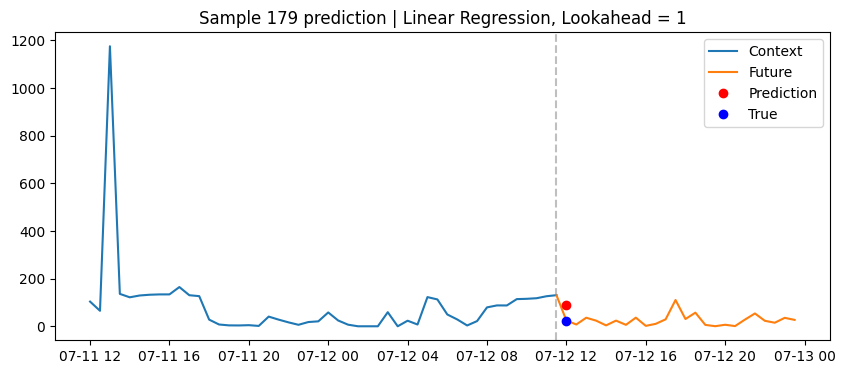

In [57]:
test_model(df_train, df_test, regression_pipeline, lookahead=1, name="Linear Regression, Lookahead = 1")

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


Results for Linear Regression, Lookahead = 7:
MSE = 4384.266440559806
RMSE = 66.21379343127688


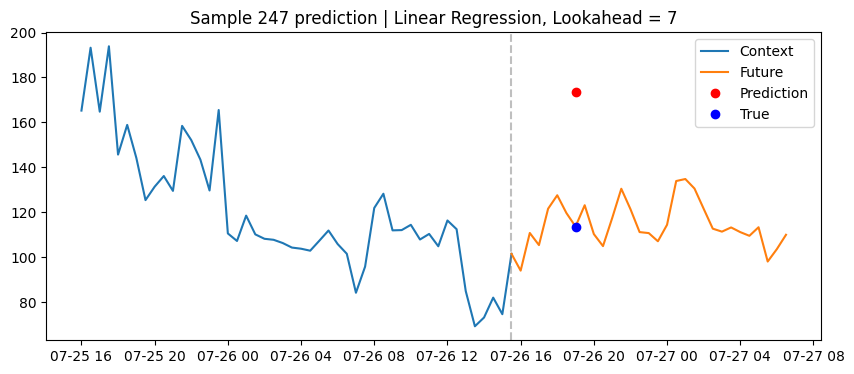

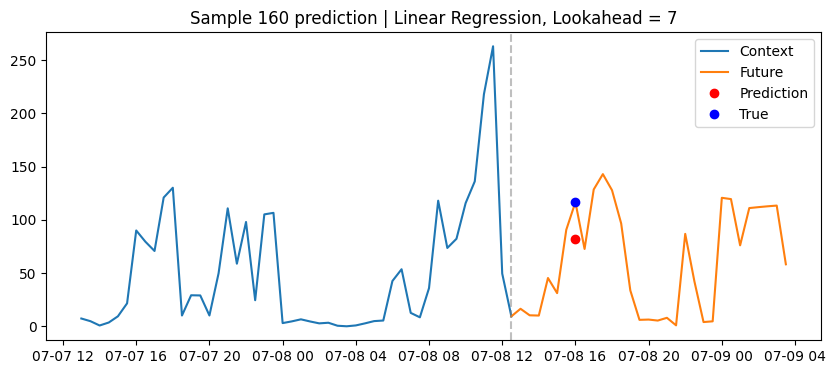

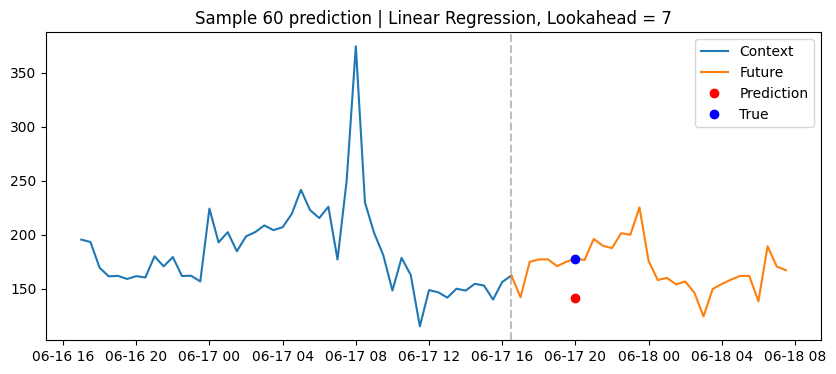

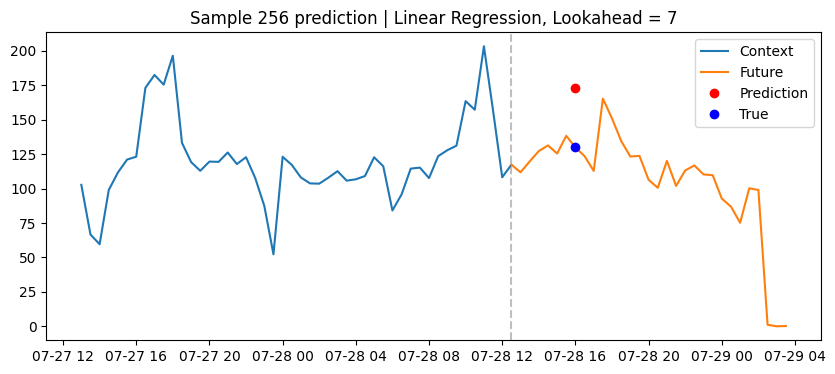

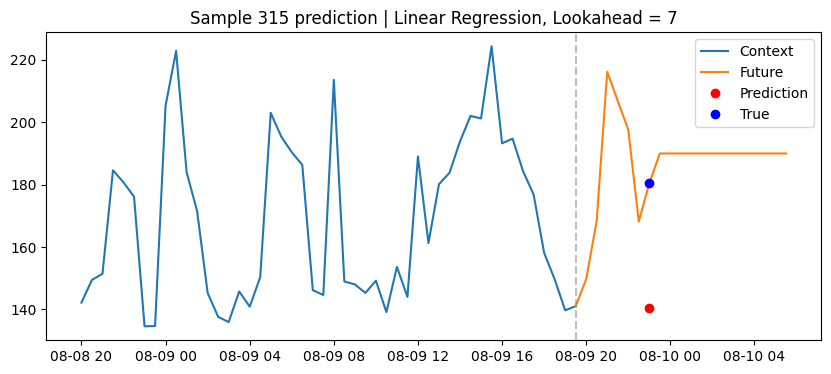

In [58]:
test_model(df_train, df_test, regression_pipeline, lookahead=7, name="Linear Regression, Lookahead = 7")

## Decision Tree Regressor

In [59]:
from sklearn.tree import DecisionTreeRegressor

dtr_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", DecisionTreeRegressor())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Results for Decision Tree Regressor, Lookahead = 1:
MSE = 5674.954423482327
RMSE = 75.33229336401705


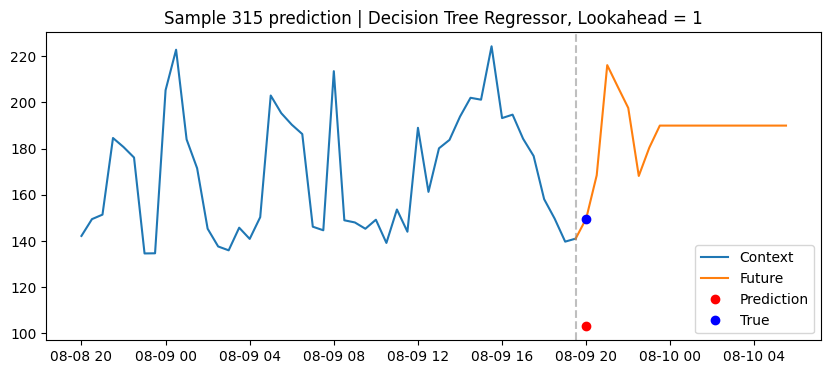

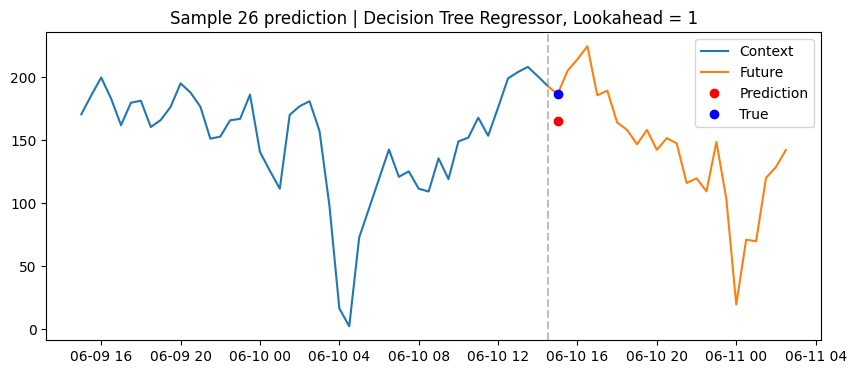

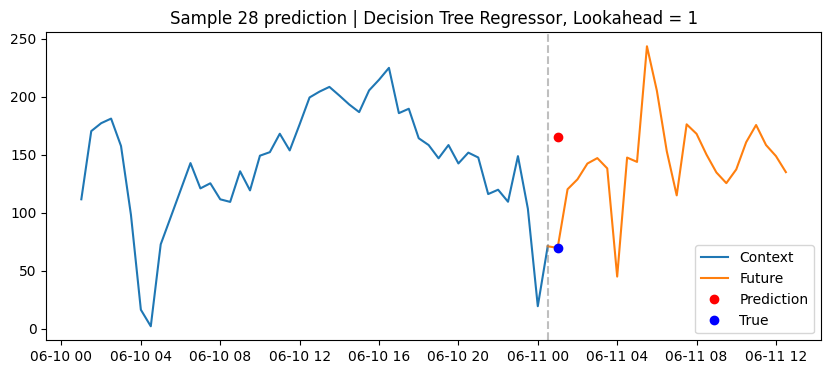

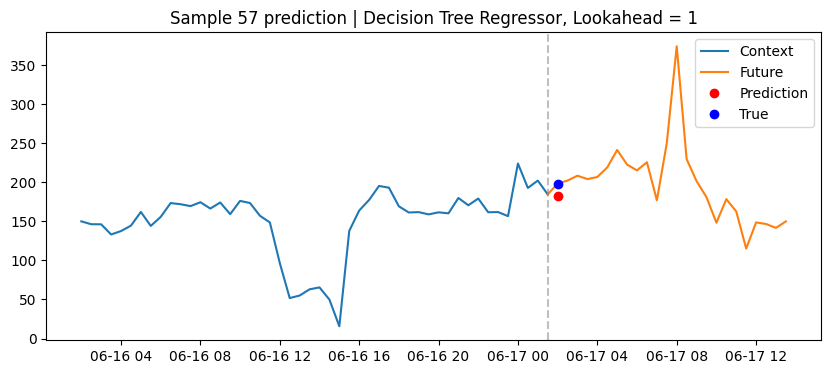

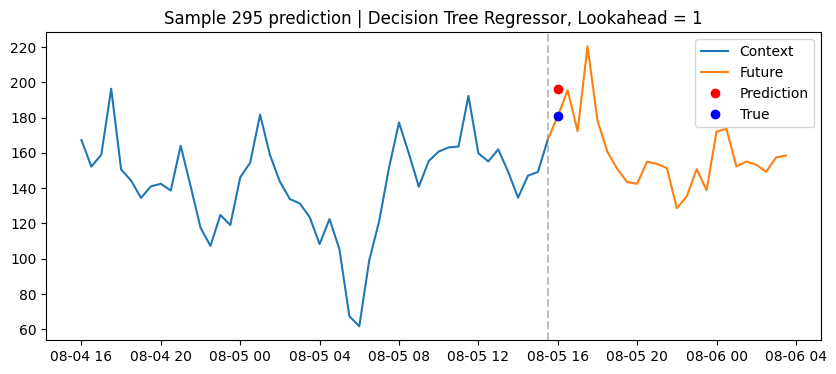

In [60]:
test_model(df_train, df_test, dtr_pipeline, lookahead=1, name="Decision Tree Regressor, Lookahead = 1")

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Results for Decision Tree Regressor, Lookahead = 7:
MSE = 7449.515455240973
RMSE = 86.31057557009439


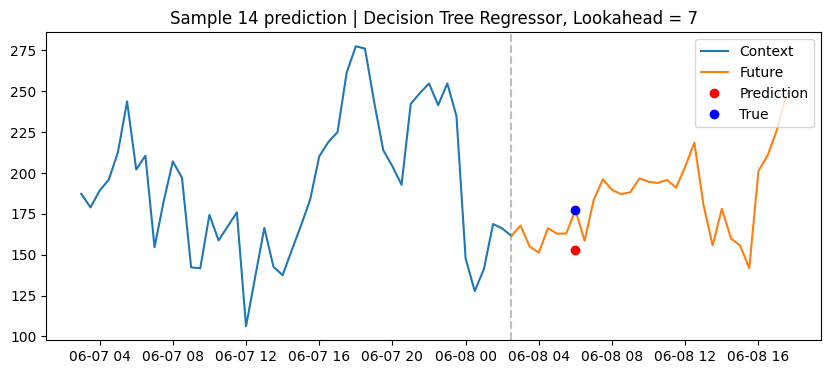

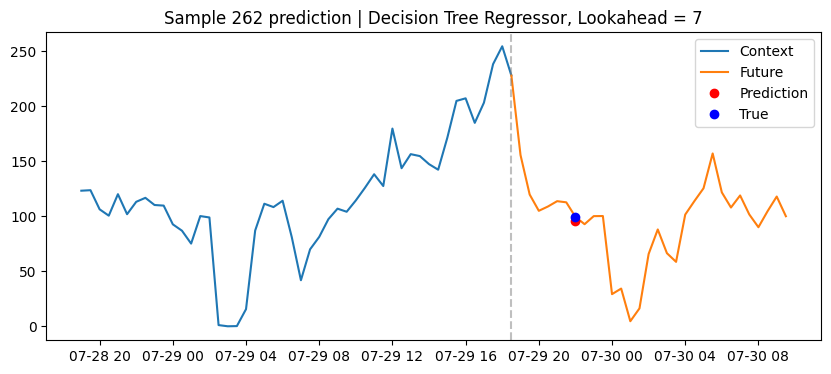

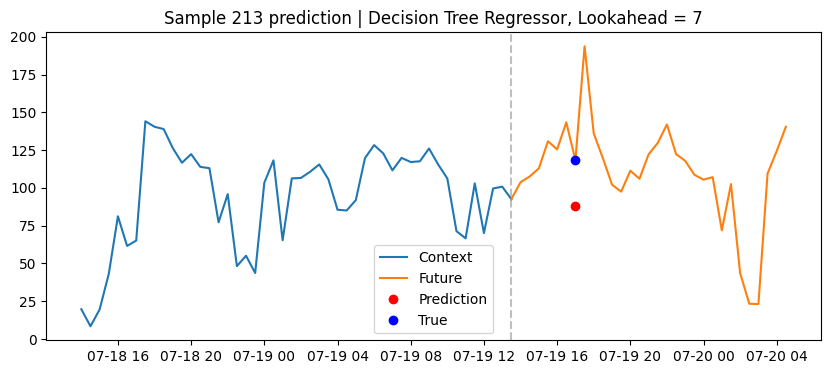

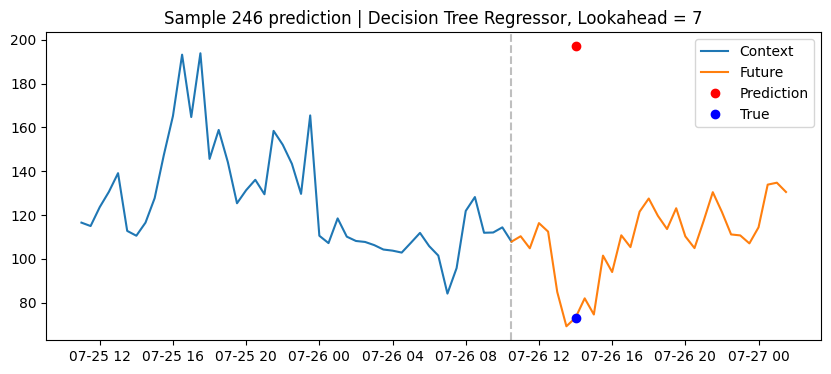

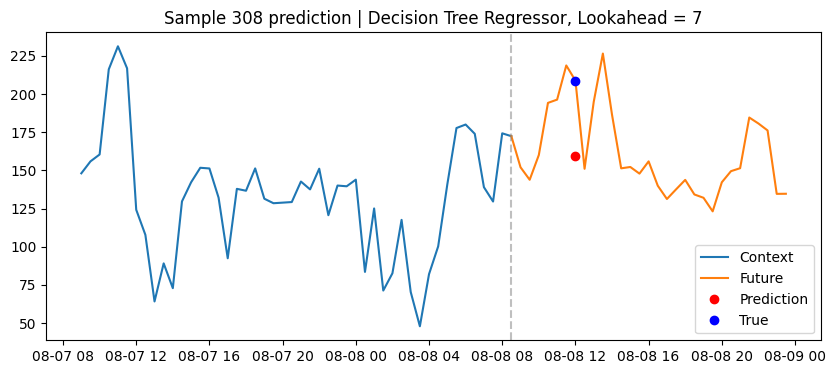

In [61]:
test_model(df_train, df_test, dtr_pipeline, lookahead=7, name="Decision Tree Regressor, Lookahead = 7")

## XG Boost

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

xgboost_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", GradientBoostingRegressor())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


Results for XG-Boost, Lookahead = 1:
MSE = 4672.476735587684
RMSE = 68.35551722858722


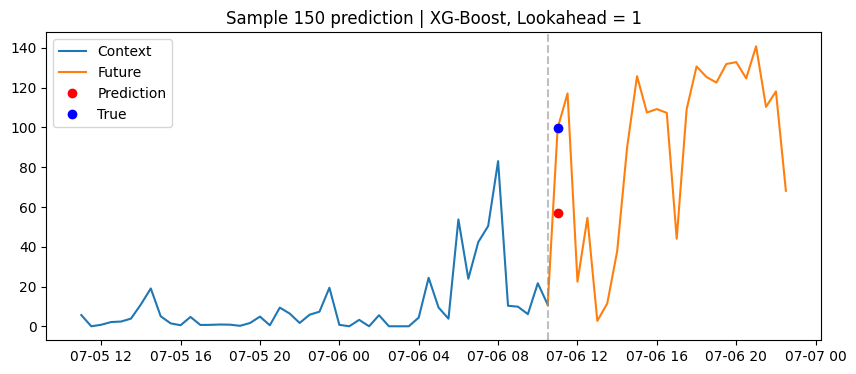

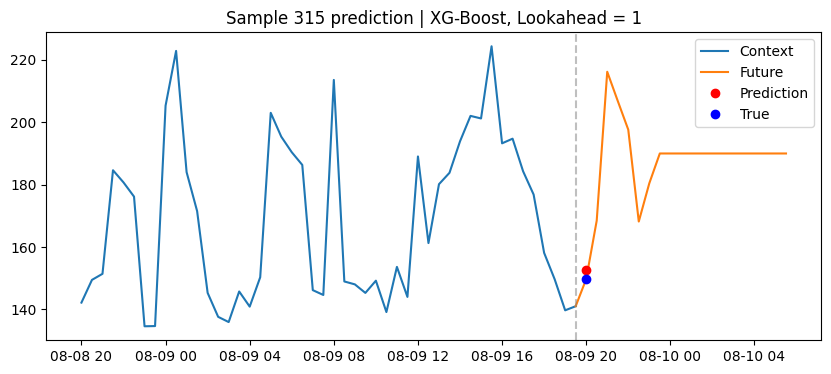

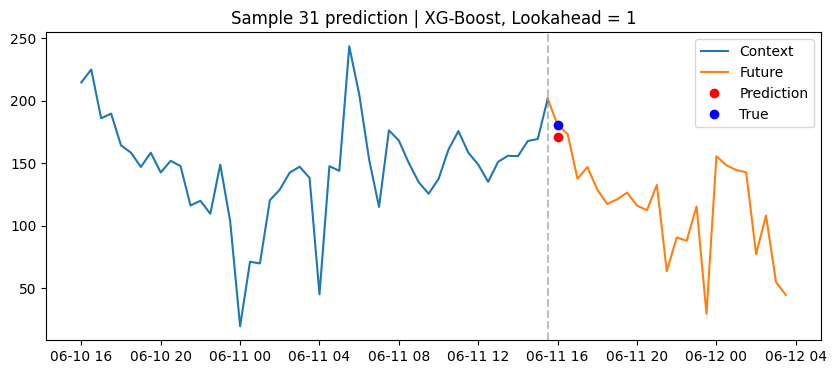

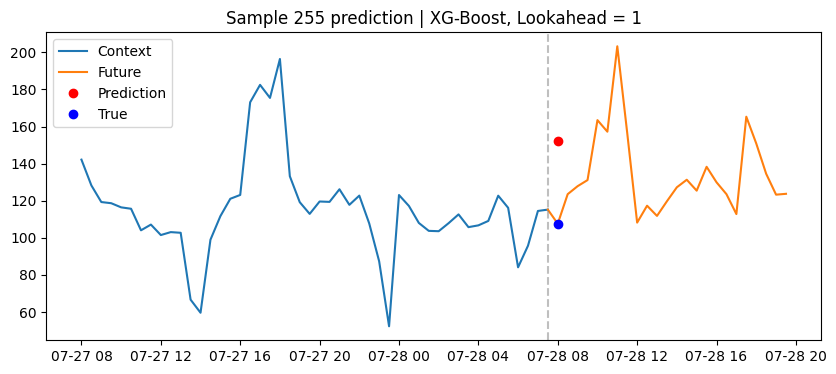

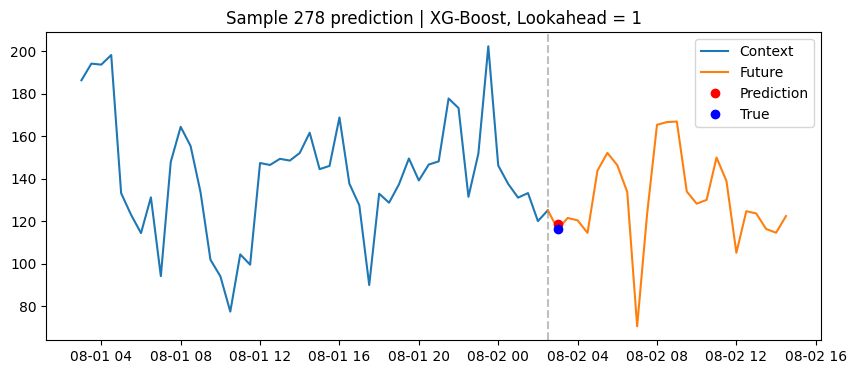

In [63]:
test_model(df_train, df_test, xgboost_pipeline, lookahead=1, name="XG-Boost, Lookahead = 1")

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


Results for XG-Boost, Lookahead = 7:
MSE = 30362.053536104857
RMSE = 174.24710481412555


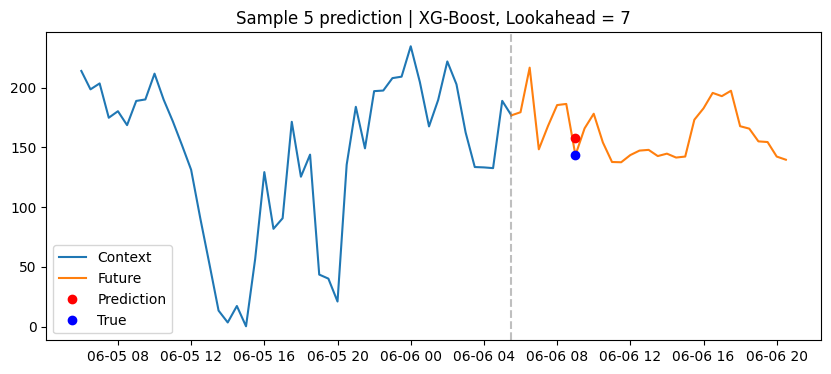

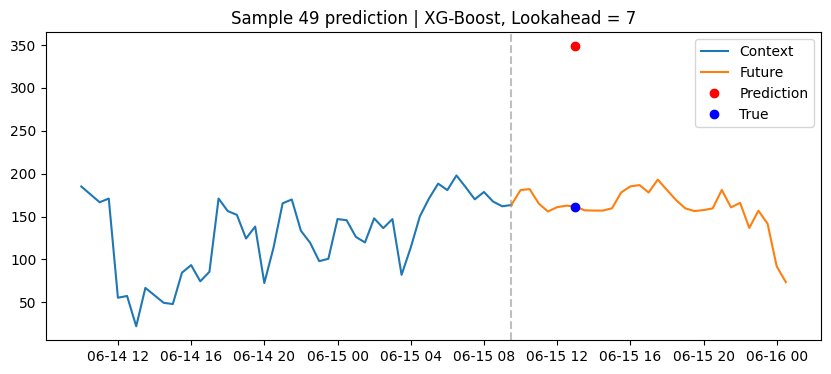

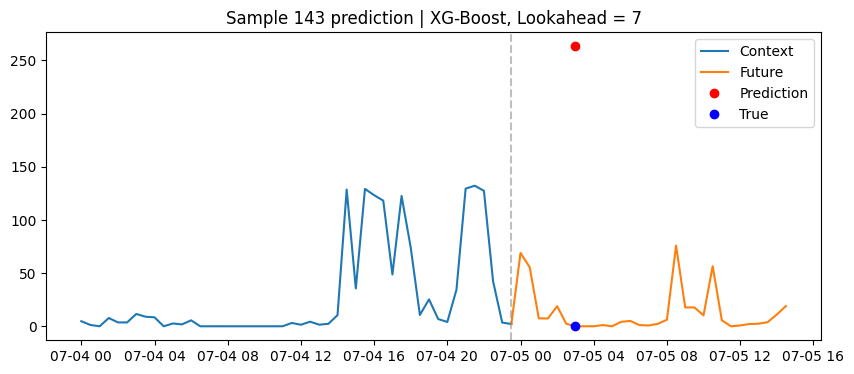

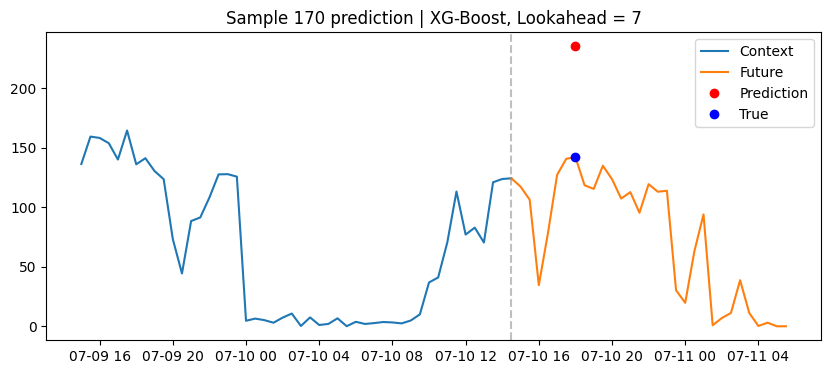

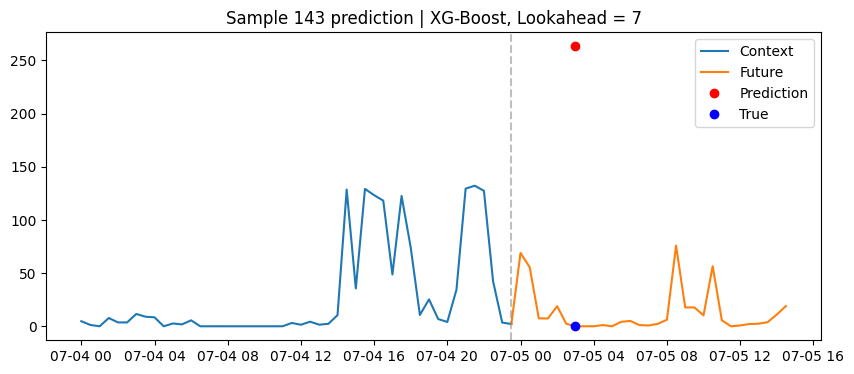

In [68]:
test_model(df_train, df_test, xgboost_pipeline, lookahead=7, name="XG-Boost, Lookahead = 7")

## Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
        ("regressor", RandomForestRegressor())
    ])

Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Results for Random Forest Regression, Lookahead = 1:
MSE = 4247.116755367562
RMSE = 65.16990682337641


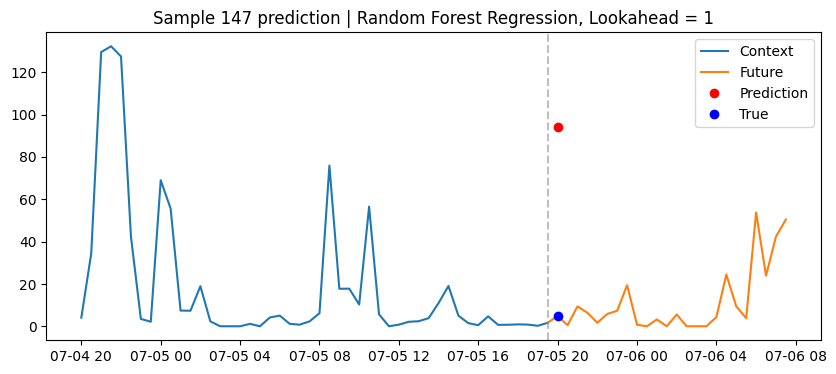

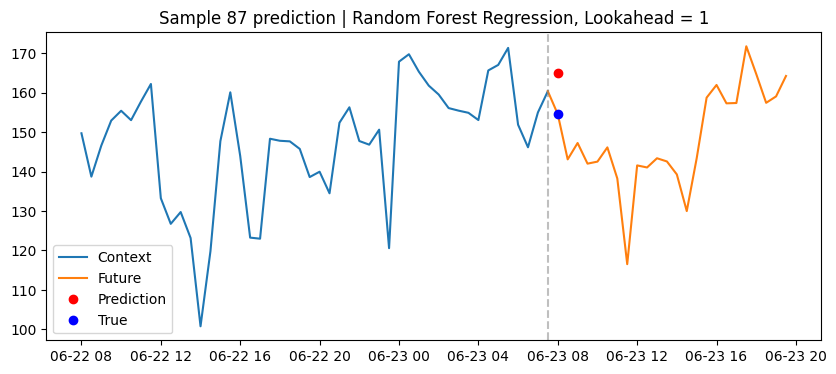

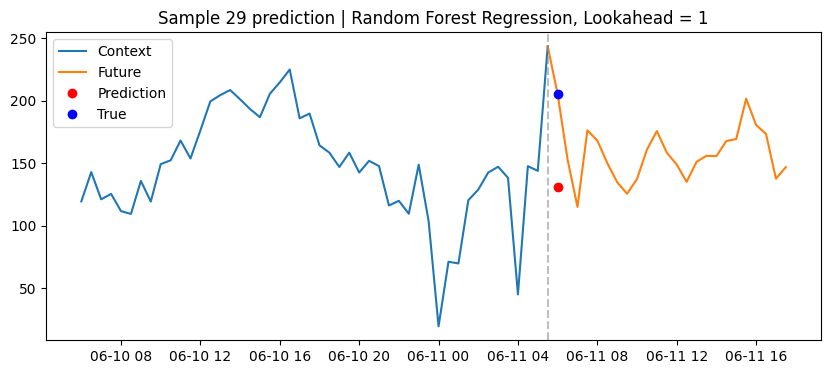

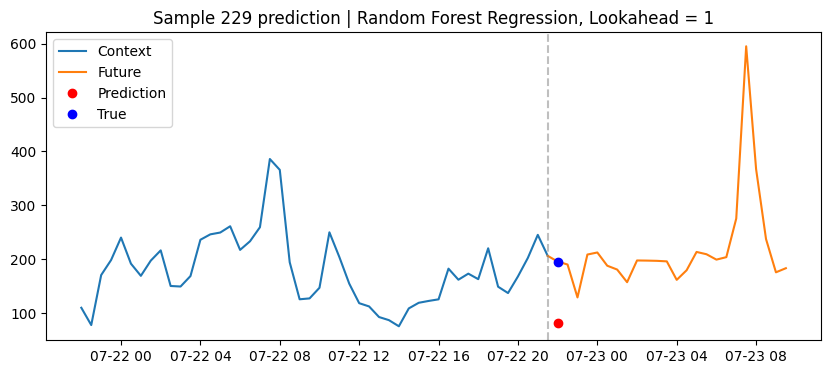

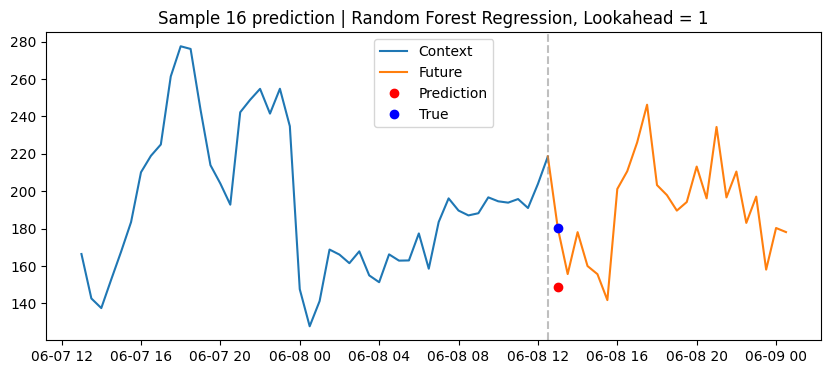

In [66]:
test_model(df_train, df_test, rf_pipeline, lookahead=1, name="Random Forest Regression, Lookahead = 1")

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Results for Random Forest Regression, Lookahead = 7:
MSE = 70377.71966355894
RMSE = 265.2879938172079


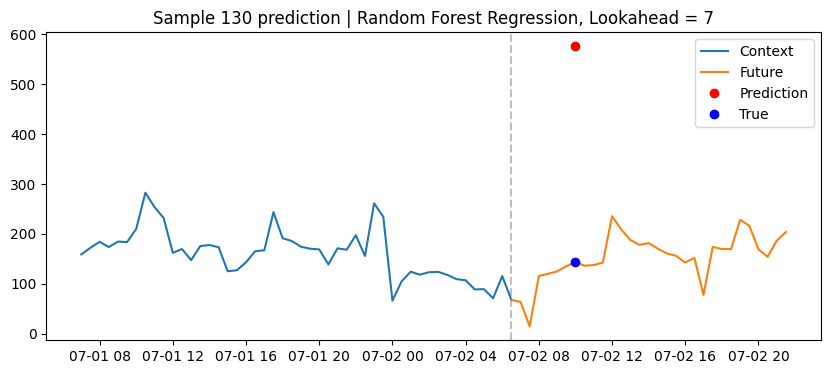

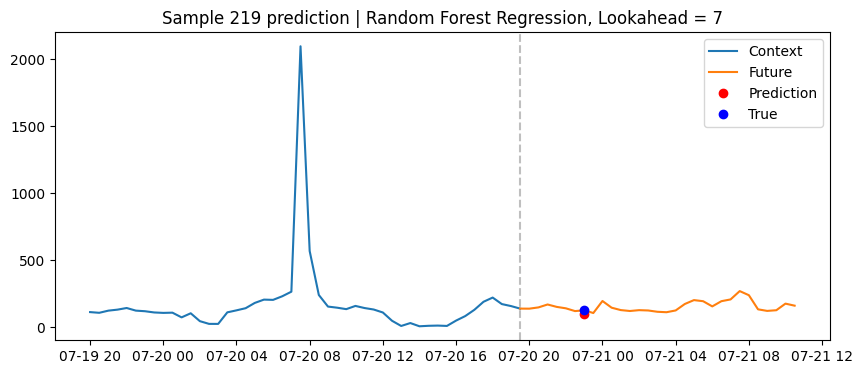

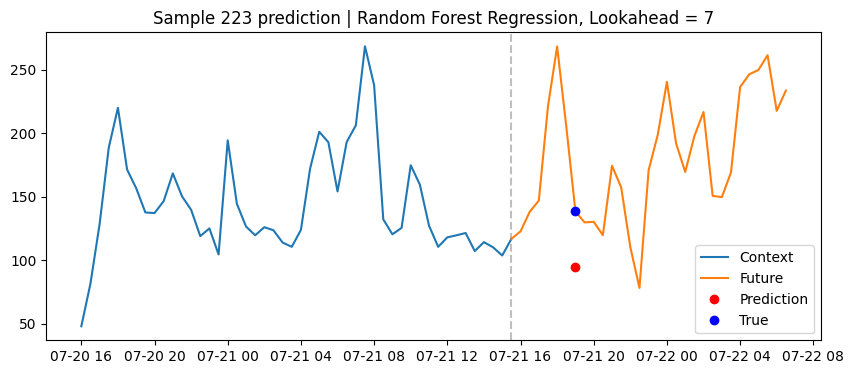

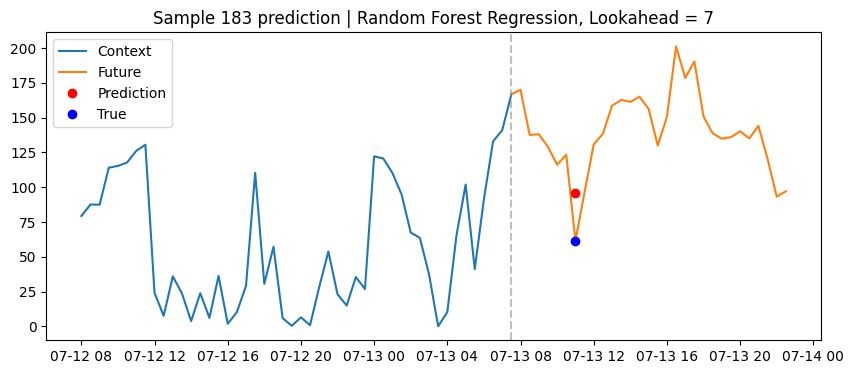

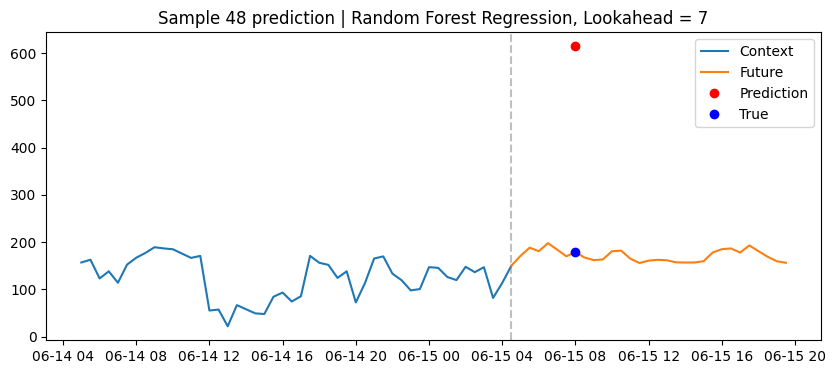

In [67]:
test_model(df_train, df_test, rf_pipeline, lookahead=7, name="Random Forest Regression, Lookahead = 7")